In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler,LabelEncoder,PolynomialFeatures
from sklearn.model_selection import train_test_split,KFold,cross_val_score,GridSearchCV
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
from scipy.optimize import differential_evolution
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import warnings
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import balanced_accuracy_score
from sklearn.feature_selection import SelectFromModel
warnings.filterwarnings("ignore")
sns.set_theme(style='darkgrid')

In [2]:
adult = pd.read_csv(r"C:\Games\FDM project\GUI\adult.csv")
adult.head(10)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
6,29,?,227026,HS-grad,9,Never-married,?,Unmarried,Black,Male,0,0,40,United-States,<=50K
7,63,Self-emp-not-inc,104626,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,>50K
8,24,Private,369667,Some-college,10,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,<=50K
9,55,Private,104996,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,<=50K


In [3]:
adult.replace('?',np.nan,inplace=True)

adult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        46043 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       46033 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   47985 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [4]:
num_of_duplicates = adult.duplicated().sum()
if num_of_duplicates>0:
    adult.drop_duplicates(inplace=True,ignore_index=True,keep="first")
    print(f"The number of duplicates rows was {num_of_duplicates} and now 0")
else :
    print("There is no duplicates")

The number of duplicates rows was 52 and now 0


In [5]:
adult.shape

(48790, 15)

In [6]:
# native-country column
adult.dropna(subset=["native-country"],inplace=True,ignore_index=True)
# workclass column
adult.fillna({"workclass":"Unknown"},inplace=True)
# Occupation column
adult.loc[adult["workclass"]=="Never-worked","occupation"]="No-job"
adult.loc[adult["workclass"]=="Unknown","occupation"]="Unknown-job"

In [7]:
adult["capital_val"]=adult["capital-gain"]-adult['capital-loss']
adult["capital"]=adult["capital_val"]
adult.loc[adult["capital_val"]>0,"capital"]="gain"
adult.loc[adult["capital_val"]<0,"capital"]="loss"
adult.loc[adult["capital_val"]==0,"capital"]="neither"
income_col=adult["income"]
adult.drop(["capital-gain","capital-loss","capital_val","income"],axis=1,inplace=True)
adult["income"]=income_col

In [8]:
adult.head(10)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,hours-per-week,native-country,capital,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,40,United-States,neither,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,50,United-States,neither,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,40,United-States,neither,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,40,United-States,gain,>50K
4,18,Unknown,103497,Some-college,10,Never-married,Unknown-job,Own-child,White,Female,30,United-States,neither,<=50K
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,30,United-States,neither,<=50K
6,29,Unknown,227026,HS-grad,9,Never-married,Unknown-job,Unmarried,Black,Male,40,United-States,neither,<=50K
7,63,Self-emp-not-inc,104626,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,32,United-States,gain,>50K
8,24,Private,369667,Some-college,10,Never-married,Other-service,Unmarried,White,Female,40,United-States,neither,<=50K
9,55,Private,104996,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,10,United-States,neither,<=50K


In [9]:
def outliers_handler(real_data:pd.DataFrame(),col_name:str)->pd.DataFrame():
    adult2=real_data.copy()
    q1 = np.percentile(adult2[col_name],25)
    q3 = np.percentile(adult2[col_name],75)
    iqr = q3-q1
    upper_bound = q3+(1.5*iqr)
    lower_bound = q1-(1.5*iqr)
    outliers = (adult2[col_name]>upper_bound) | (adult2[col_name]<lower_bound)
    num_of_outliers = len(adult2[outliers])
    if num_of_outliers <= len(adult2)*0.1:
        adult2 = adult2[~outliers]
        print("Outliers dropped")
    else:
        adult2.loc[adult2[col_name]>upper_bound,col_name] = upper_bound
        adult2.loc[adult2[col_name]<lower_bound,col_name] = lower_bound
        print("Outliers replaced")
    return adult2

In [10]:
for i in ["age","hours-per-week"]:
    adult=outliers_handler(adult,i)

Outliers dropped
Outliers replaced


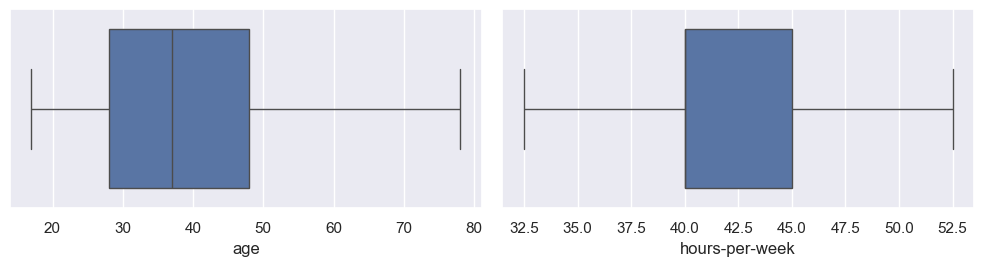

In [11]:
plt.figure(figsize=(10,5))
i=1
for col in adult.select_dtypes(exclude="object").columns :
    if col in ["fnlwgt","educational-num"]:
        continue
    plt.subplot(2,2,i)
    sns.boxplot(data=adult,x=col)
    i+=1
plt.tight_layout()
plt.show()

In [12]:
adult['workclass'].unique()

array(['Private', 'Local-gov', 'Unknown', 'Self-emp-not-inc',
       'Federal-gov', 'State-gov', 'Self-emp-inc', 'Without-pay',
       'Never-worked'], dtype=object)

In [13]:
education_mapping = {
    'HS-grad': 'High School',
    'Some-college': 'Some College',
    '10th': 'Less than High School',
    '11th': 'Less than High School',
    '7th-8th': 'Less than High School',
    '9th': 'Less than High School',
    'Assoc-acdm': 'Associate Degree',
    'Assoc-voc': 'Associate Degree',
    'Bachelors': 'Bachelor\'s Degree',
    'Masters': 'Master\'s Degree',
    'Doctorate': 'Doctorate Degree',
    'Prof-school': 'Professional Degree',
    '5th-6th': 'Less than High School',
    '12th': 'Less than High School',
    '1st-4th': 'Less than High School',
    'Preschool': 'Less than High School'
}

adult['education'] = adult['education'].replace(education_mapping)

In [14]:
adult['education'].unique()

array(['Less than High School', 'High School', 'Associate Degree',
       'Some College', 'Professional Degree', "Bachelor's Degree",
       "Master's Degree", 'Doctorate Degree'], dtype=object)

In [15]:
adult.head(10)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,hours-per-week,native-country,capital,income
0,25,Private,226802,Less than High School,7,Never-married,Machine-op-inspct,Own-child,Black,Male,40.0,United-States,neither,<=50K
1,38,Private,89814,High School,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,50.0,United-States,neither,<=50K
2,28,Local-gov,336951,Associate Degree,12,Married-civ-spouse,Protective-serv,Husband,White,Male,40.0,United-States,neither,>50K
3,44,Private,160323,Some College,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,40.0,United-States,gain,>50K
4,18,Unknown,103497,Some College,10,Never-married,Unknown-job,Own-child,White,Female,32.5,United-States,neither,<=50K
5,34,Private,198693,Less than High School,6,Never-married,Other-service,Not-in-family,White,Male,32.5,United-States,neither,<=50K
6,29,Unknown,227026,High School,9,Never-married,Unknown-job,Unmarried,Black,Male,40.0,United-States,neither,<=50K
7,63,Self-emp-not-inc,104626,Professional Degree,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,32.5,United-States,gain,>50K
8,24,Private,369667,Some College,10,Never-married,Other-service,Unmarried,White,Female,40.0,United-States,neither,<=50K
9,55,Private,104996,Less than High School,4,Married-civ-spouse,Craft-repair,Husband,White,Male,32.5,United-States,neither,<=50K


In [16]:
adult.head(10)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,hours-per-week,native-country,capital,income
0,25,Private,226802,Less than High School,7,Never-married,Machine-op-inspct,Own-child,Black,Male,40.0,United-States,neither,<=50K
1,38,Private,89814,High School,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,50.0,United-States,neither,<=50K
2,28,Local-gov,336951,Associate Degree,12,Married-civ-spouse,Protective-serv,Husband,White,Male,40.0,United-States,neither,>50K
3,44,Private,160323,Some College,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,40.0,United-States,gain,>50K
4,18,Unknown,103497,Some College,10,Never-married,Unknown-job,Own-child,White,Female,32.5,United-States,neither,<=50K
5,34,Private,198693,Less than High School,6,Never-married,Other-service,Not-in-family,White,Male,32.5,United-States,neither,<=50K
6,29,Unknown,227026,High School,9,Never-married,Unknown-job,Unmarried,Black,Male,40.0,United-States,neither,<=50K
7,63,Self-emp-not-inc,104626,Professional Degree,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,32.5,United-States,gain,>50K
8,24,Private,369667,Some College,10,Never-married,Other-service,Unmarried,White,Female,40.0,United-States,neither,<=50K
9,55,Private,104996,Less than High School,4,Married-civ-spouse,Craft-repair,Husband,White,Male,32.5,United-States,neither,<=50K


In [17]:
work=pd.DataFrame(round(adult.workclass.value_counts()*100/len(adult),2))
work

,count
workclass,
Private,69.50
Self-emp-not-inc,7.87
Local-gov,6.47
Unknown,5.66
State-gov,4.08
Self-emp-inc,3.42
Federal-gov,2.94
Without-pay,0.04
Never-worked,0.02


In [18]:
adult.loc[(adult["workclass"]!="Private"),"workclass"]="Others"

In [19]:
occ=pd.DataFrame(round(adult.occupation.value_counts()*100/len(adult),2))
occ

,count
occupation,
Craft-repair,12.58
Prof-specialty,12.52
Exec-managerial,12.46
Adm-clerical,11.56
Sales,11.28
Other-service,10.03
Machine-op-inspct,6.20
Unknown-job,5.66
Transport-moving,4.84


In [20]:
li=occ.tail(10).index.tolist()
adult.loc[(adult["occupation"].isin(li)),"occupation"]="Others"

In [21]:
ed=pd.DataFrame(round(adult.education.value_counts()*100/len(adult),2))
ed

,count
education,
High School,32.49
Some College,22.39
Bachelor's Degree,16.30
Less than High School,13.05
Associate Degree,7.56
Master's Degree,5.38
Professional Degree,1.67
Doctorate Degree,1.17


In [22]:
li=ed.tail(3).index.tolist()
adult.loc[(adult["education"].isin(li)),"education"]="Others"

In [23]:
marital=pd.DataFrame(round(adult["marital-status"].value_counts()*100/len(adult),2))
marital

,count
marital-status,
Married-civ-spouse,45.81
Never-married,33.01
Divorced,13.72
Separated,3.15
Widowed,3.00
Married-spouse-absent,1.23
Married-AF-spouse,0.08


In [24]:
li=marital.tail(5).index.tolist()
adult.loc[(adult["marital-status"].isin(li)),"marital-status"]="Others"

In [25]:
race=pd.DataFrame(round(adult["race"].value_counts()*100/len(adult),2))
race

,count
race,
White,85.81
Black,9.52
Asian-Pac-Islander,2.90
Amer-Indian-Eskimo,0.98
Other,0.80


In [26]:
li=race.tail(3).index.tolist()
adult.loc[(adult["race"].isin(li)),"race"]="Others"

In [27]:
adult.drop('education', axis=1, inplace=True)

In [28]:
X=adult.drop(["income"],axis=1)
y=adult.income

In [29]:
categorical_cols = X.select_dtypes(include="object").columns.tolist()
onehot_encoder = OneHotEncoder(drop='first', sparse_output=False)
X_onehot = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_onehot, y, train_size=0.8, random_state=42)

In [31]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for clarity
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_onehot.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_onehot.columns)

In [32]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=1000, max_depth=5)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=5, n_estimators=1000, n_jobs=-1,
                       random_state=42)

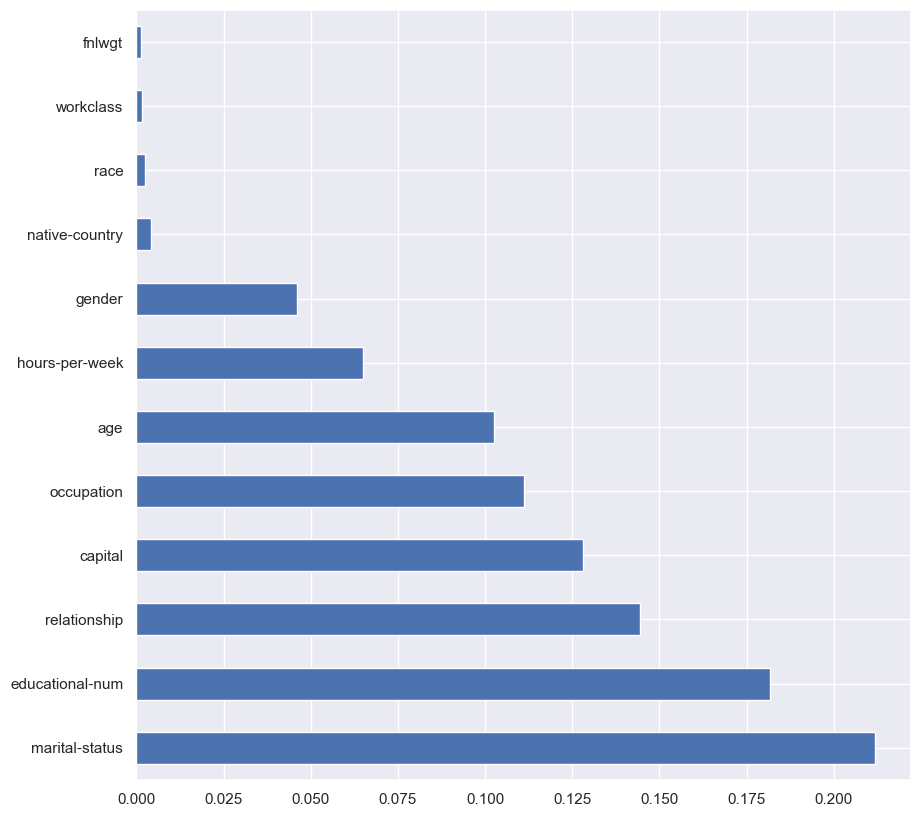

In [33]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train_scaled.columns)

def aggregate_feature_importance(feat_importances, categorical_cols):
    original_importances = {}

    for col in feat_importances.index:
        # Identify the original column name (before one-hot encoding)
        original_col = col.split('_')[0] if '_' in col else col

        # Sum the importances for all one-hot encoded components of the same original column
        if original_col in original_importances:
            original_importances[original_col] += feat_importances[col]
        else:
            original_importances[original_col] = feat_importances[col]

    return pd.Series(original_importances)

# Aggregate feature importances
aggregated_importances = aggregate_feature_importance(feat_importances, categorical_cols)

# Plot the aggregated feature importances
plt.figure(figsize=(10, 10))
aggregated_importances.nlargest(15).plot(kind='barh')
plt.show()

In [34]:
selector = SelectFromModel(rf, threshold=0.05, prefit=True)
selected_features = X_train_scaled.columns[selector.get_support()]
print("Selected Features: ", selected_features)

Selected Features:  Index(['age', 'educational-num', 'hours-per-week',
       'marital-status_Never-married', 'marital-status_Others',
       'relationship_Not-in-family', 'capital_neither'],
      dtype='object')


In [35]:
adult.shape

(47724, 13)

### Second Part

In [36]:
adult.drop(["fnlwgt", "workclass", "race", "native-country", "gender"],axis=1,inplace=True)

In [37]:
adult.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47724 entries, 0 to 47933
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              47724 non-null  int64  
 1   educational-num  47724 non-null  int64  
 2   marital-status   47724 non-null  object 
 3   occupation       47724 non-null  object 
 4   relationship     47724 non-null  object 
 5   hours-per-week   47724 non-null  float64
 6   capital          47724 non-null  object 
 7   income           47724 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 3.3+ MB


In [40]:
# One-hot encode categorical columns
categorical_cols = ['marital-status', 'occupation', 'relationship', 'capital', 'income']
adult_encoded = pd.get_dummies(adult, columns=categorical_cols, drop_first=True)

adult_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47724 entries, 0 to 47933
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           47724 non-null  int64  
 1   educational-num               47724 non-null  int64  
 2   hours-per-week                47724 non-null  float64
 3   marital-status_Never-married  47724 non-null  bool   
 4   marital-status_Others         47724 non-null  bool   
 5   occupation_Craft-repair       47724 non-null  bool   
 6   occupation_Exec-managerial    47724 non-null  bool   
 7   occupation_Other-service      47724 non-null  bool   
 8   occupation_Others             47724 non-null  bool   
 9   occupation_Prof-specialty     47724 non-null  bool   
 10  occupation_Sales              47724 non-null  bool   
 11  relationship_Not-in-family    47724 non-null  bool   
 12  relationship_Other-relative   47724 non-null  bool   
 13  relati

In [41]:
adult.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47724 entries, 0 to 47933
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              47724 non-null  int64  
 1   educational-num  47724 non-null  int64  
 2   marital-status   47724 non-null  object 
 3   occupation       47724 non-null  object 
 4   relationship     47724 non-null  object 
 5   hours-per-week   47724 non-null  float64
 6   capital          47724 non-null  object 
 7   income           47724 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 3.3+ MB


In [43]:
X=adult_encoded.drop(["income_>50K"],axis=1)
y=adult_encoded["income_>50K"]

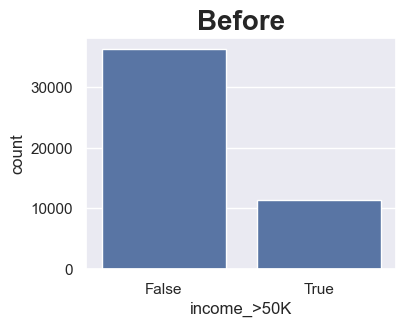

In [44]:
plt.figure(figsize=(4,3))
plt.title("Before",fontsize=20,weight="bold")
sns.countplot(x=y)
plt.show()

In [45]:
resampler = SMOTE()
X,y = resampler.fit_resample(X,y)


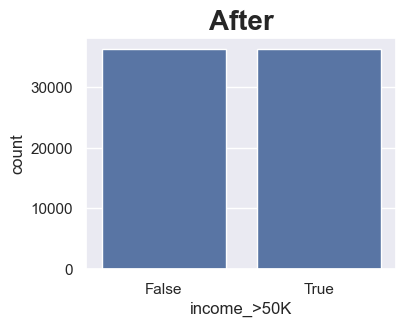

In [46]:
plt.figure(figsize=(4,3))
plt.title("After",fontsize=20,weight="bold")
sns.countplot(x=y)
plt.show()

In [47]:
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=42)

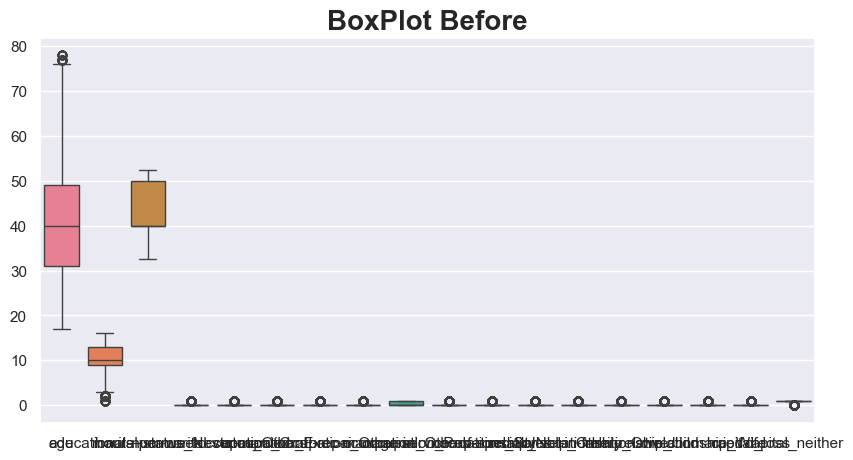

In [48]:
plt.figure(figsize=(10,5))
plt.title("BoxPlot Before",fontsize=20,weight="bold")
sns.boxplot(x_train)
plt.show()

In [49]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train=pd.DataFrame(x_train,columns=X.columns.tolist())
x_test=pd.DataFrame(x_test,columns=X.columns.tolist())

**Decision Tree**

In [50]:
par={
    "max_depth":(3,12),
    "criterion":(0,1),
    "min_impurity_decrease":(0,0.001)
}

def evaluation_func(par):
    max_depth=int(par[0])
    criterion="gini" if int(par[1])==0 else "entropy"
    min_impurity_decrease=float(par[2])
    clf=DecisionTreeClassifier(criterion=criterion
                               ,max_depth=max_depth
                               ,min_impurity_decrease=min_impurity_decrease
                               ,random_state=41)
    clf.fit(x_train,y_train)
    return - clf.score(x_test,y_test)

np.random.seed(41)
res = differential_evolution(evaluation_func,
                             bounds=list(par.values()),
                             maxiter=15,
                             mutation=0.9,
                             recombination=0.8,
                             popsize=20)

print(f"Parameters: {res.x}\nScore: {-res.fun*100:.2f}")

Parameters: [1.00587795e+01 2.63771358e-01 1.12802707e-05]
Score: 82.16


In [51]:
criterion = "gini" if int(res.x[1])==0 else "entropy"
print(f"Criterion --> {criterion}\n\n")
dst = DecisionTreeClassifier(criterion=criterion,
                             max_depth=int(res.x[0]),
                             min_impurity_decrease=float(res.x[2])
                             ,random_state=41)
dst.fit(x_train,y_train)

Criterion --> gini




DecisionTreeClassifier(max_depth=10,
                       min_impurity_decrease=1.1280270685176002e-05,
                       random_state=41)

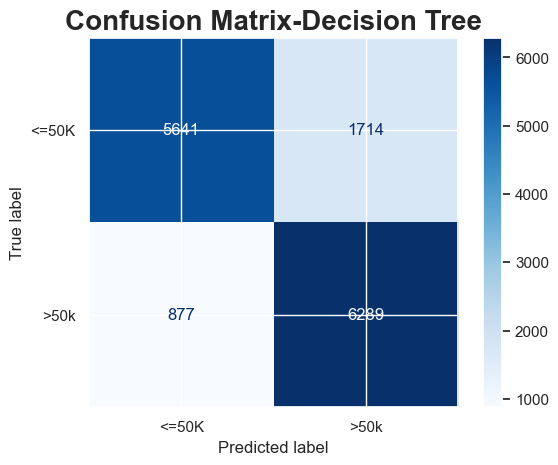

In [66]:
y_pred=dst.predict(x_test)
matrix=confusion_matrix(y_test,y_pred)
figure=ConfusionMatrixDisplay(matrix,display_labels=["<=50K",">50k"])
figure.plot(cmap="Blues")
plt.title("Confusion Matrix-Decision Tree",fontsize=20,weight="bold")
plt.show()

Train Score: 83.33
Test Score: 82.16
              precision    recall  f1-score   support

       False       0.87      0.77      0.81      7355
        True       0.79      0.88      0.83      7166

    accuracy                           0.82     14521
   macro avg       0.83      0.82      0.82     14521
weighted avg       0.83      0.82      0.82     14521

In [53]:
train_score=dst.score(x_train,y_train)
test_score=dst.score(x_test,y_test)
print(f"Train Score: {train_score*100:.2f}\nTest Score: {test_score*100:.2f}")
report=classification_report(y_test,y_pred)
print(report)

Train Score: 83.33
Test Score: 82.16
              precision    recall  f1-score   support

       False       0.87      0.77      0.81      7355
        True       0.79      0.88      0.83      7166

    accuracy                           0.82     14521
   macro avg       0.83      0.82      0.82     14521
weighted avg       0.83      0.82      0.82     14521



**Random Forrest and Hyperparameters Tuning**

In [54]:
par={
    "max_depth": (2, 20),
    "n_estimators" : (100,300)
}

def evaluation_func(par):
    max_depth = int(par[0])
    n_estimators=int(par[1])
    clf= RandomForestClassifier(max_depth=max_depth,
                              n_estimators=n_estimators,
                              random_state=41)
    clf.fit(x_train,y_train)
    return - clf.score(x_test,y_test) # want to max


np.random.seed(41)
result = differential_evolution(
    evaluation_func,
    bounds=list(par.values()),
    maxiter=15,
    popsize=5,
    mutation=0.9,
    recombination=0.8,
)
print(f"Parameters: {result.x}\nScore: {-result.fun*100:.2f}")

Parameters: [ 19.01921506 191.0539023 ]
Score: 84.86


In [55]:
rfc = RandomForestClassifier(max_depth=int(result.x[0]),
                              n_estimators=int(result.x[1]),
                              random_state=41)
rfc.fit(x_train,y_train)

RandomForestClassifier(max_depth=19, n_estimators=191, random_state=41)

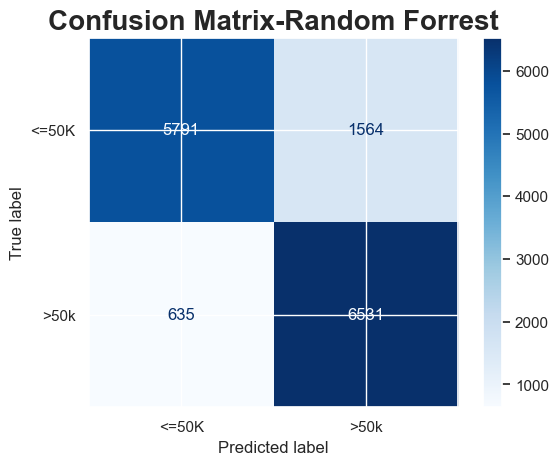

In [68]:
y_pred=rfc.predict(x_test)
matrix=confusion_matrix(y_test,y_pred)
figure=ConfusionMatrixDisplay(matrix,display_labels=["<=50K",">50k"])
figure.plot(cmap="Blues")
plt.title("Confusion Matrix-Random Forrest",fontsize=20,weight="bold")
plt.show()

In [57]:
train_score=rfc.score(x_train,y_train)
test_score=rfc.score(x_test,y_test)
print(f"Train Score: {train_score*100:.2f}\nTest Score: {test_score*100:.2f}")
report=classification_report(y_test,y_pred)
print(report)

Train Score: 89.09
Test Score: 84.86
              precision    recall  f1-score   support

       False       0.90      0.79      0.84      7355
        True       0.81      0.91      0.86      7166

    accuracy                           0.85     14521
   macro avg       0.85      0.85      0.85     14521
weighted avg       0.85      0.85      0.85     14521



In [58]:
from joblib import dump


dump(rfc, 'random_forest_model.joblib')
dump(scaler, 'scaler.joblib')

['scaler.joblib']

**Logistic** **Regression**

Parameters: [2.87893328 0.44532529]
Score: 80.57
Penalty --> l2




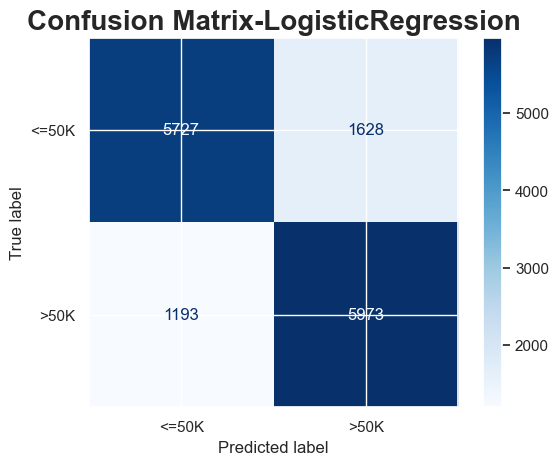

Train Score: 80.75
Test Score: 80.57
              precision    recall  f1-score   support

       False       0.83      0.78      0.80      7355
        True       0.79      0.83      0.81      7166

    accuracy                           0.81     14521
   macro avg       0.81      0.81      0.81     14521
weighted avg       0.81      0.81      0.81     14521



In [69]:
par = {
    "C": (0.01, 10),
    "penalty": (0, 1)  # 0: l2, 1: none
}

def evaluation_func(par):
    C = float(par[0])
    penalty = 'l2' if int(par[1]) == 0 else 'none'
    clf = LogisticRegression(C=C, penalty=penalty, solver='lbfgs', max_iter=1000, random_state=41)
    clf.fit(x_train, y_train)
    return -clf.score(x_test, y_test)

res = differential_evolution(evaluation_func, bounds=list(par.values()), maxiter=15, mutation=0.9, recombination=0.8, popsize=20)

print(f"Parameters: {res.x}\nScore: {-res.fun*100:.2f}")

C = float(res.x[0])
penalty = 'l2' if int(res.x[1]) == 0 else 'none'
print(f"Penalty --> {penalty}\n\n")
clf = LogisticRegression(C=C, penalty=penalty, solver='lbfgs', max_iter=1000, random_state=41)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
matrix = confusion_matrix(y_test, y_pred)
figure = ConfusionMatrixDisplay(matrix, display_labels=["<=50K", ">50K"])
figure.plot(cmap="Blues")
plt.title("Confusion Matrix-LogisticRegression", fontsize=20, weight="bold")
plt.show()

train_score = clf.score(x_train, y_train)
test_score = clf.score(x_test, y_test)
print(f"Train Score: {train_score*100:.2f}\nTest Score: {test_score*100:.2f}")
report = classification_report(y_test, y_pred)
print(report)


**K**-**Nearest** **Neighbors**

Parameters: [5.89882806 1.89421884]
Score: 83.13
Distance Metric --> Manhattan




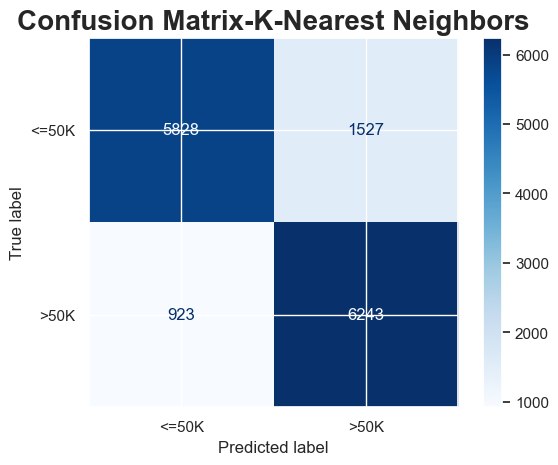

Train Score: 87.20
Test Score: 83.13
              precision    recall  f1-score   support

       False       0.86      0.79      0.83      7355
        True       0.80      0.87      0.84      7166

    accuracy                           0.83     14521
   macro avg       0.83      0.83      0.83     14521
weighted avg       0.83      0.83      0.83     14521



In [70]:
par = {
    "n_neighbors": (3, 15),
    "p": (1, 2)  # 1: Manhattan, 2: Euclidean
}

def evaluation_func(par):
    n_neighbors = int(par[0])
    p = int(par[1])
    clf = KNeighborsClassifier(n_neighbors=n_neighbors, p=p)
    clf.fit(x_train, y_train)
    return -clf.score(x_test, y_test)

res = differential_evolution(evaluation_func, bounds=list(par.values()), maxiter=15, mutation=0.9, recombination=0.8, popsize=20)

print(f"Parameters: {res.x}\nScore: {-res.fun*100:.2f}")

n_neighbors = int(res.x[0])
p = int(res.x[1])
print(f"Distance Metric --> {'Manhattan' if p == 1 else 'Euclidean'}\n\n")
clf = KNeighborsClassifier(n_neighbors=n_neighbors, p=p)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
matrix = confusion_matrix(y_test, y_pred)
figure = ConfusionMatrixDisplay(matrix, display_labels=["<=50K", ">50K"])
figure.plot(cmap="Blues")
plt.title("Confusion Matrix-K-Nearest Neighbors", fontsize=20, weight="bold")
plt.show()

train_score = clf.score(x_train, y_train)
test_score = clf.score(x_test, y_test)
print(f"Train Score: {train_score*100:.2f}\nTest Score: {test_score*100:.2f}")
report = classification_report(y_test, y_pred)
print(report)


**XGBoost**

Parameters: [4.60811056e+02 1.23628657e-01 9.27760505e+00]
Score: 85.28


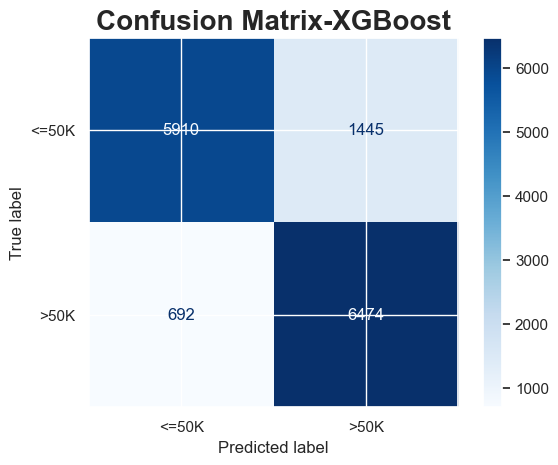

Train Score: 89.83
Test Score: 85.28
              precision    recall  f1-score   support

       <=50K       0.90      0.80      0.85      7355
        >50K       0.82      0.90      0.86      7166

    accuracy                           0.85     14521
   macro avg       0.86      0.85      0.85     14521
weighted avg       0.86      0.85      0.85     14521



In [71]:
par = {
    "n_estimators": (50, 500),
    "learning_rate": (0.01, 0.3),
    "max_depth": (3, 10)
}

def evaluation_func(par):
    n_estimators = int(par[0])
    learning_rate = float(par[1])
    max_depth = int(par[2])
    clf = XGBClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=41)
    clf.fit(x_train, y_train)
    return -clf.score(x_test, y_test)

# Perform differential evolution to optimize hyperparameters
res = differential_evolution(evaluation_func, bounds=list(par.values()), maxiter=15, mutation=0.9, recombination=0.8, popsize=20)

# Extract best hyperparameters and print them
print(f"Parameters: {res.x}\nScore: {-res.fun*100:.2f}")

n_estimators = int(res.x[0])
learning_rate = float(res.x[1])
max_depth = int(res.x[2])

# Train the final model with optimized hyperparameters
clf = XGBClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=41)
clf.fit(x_train, y_train)

# Make predictions
y_pred = clf.predict(x_test)

# Display confusion matrix
matrix = confusion_matrix(y_test, y_pred)
figure = ConfusionMatrixDisplay(matrix, display_labels=["<=50K", ">50K"])
figure.plot(cmap="Blues")
plt.title("Confusion Matrix-XGBoost", fontsize=20, weight="bold")
plt.show()

# Print training and testing accuracy
train_score = clf.score(x_train, y_train)
test_score = clf.score(x_test, y_test)
print(f"Train Score: {train_score*100:.2f}\nTest Score: {test_score*100:.2f}")

# Print classification report
report = classification_report(y_test, y_pred, target_names=["<=50K", ">50K"])
print(report)


**Support Vector Machine (SVM)**

In [63]:
joblib.dump(clf, 'xgb_model.joblib')

['xgb_model.joblib']

**Support Vector Classifier**

In [ ]:
from sklearn.svm import SVC  # Import SVC for Support Vector Classifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

par = {
    "C": (0.01, 10),
    "kernel": (0, 1)  # 0: linear, 1: rbf
}

def evaluation_func(par):
    C = float(par[0])
    kernel = 'linear' if int(par[1]) == 0 else 'rbf'
    clf = SVC(C=C, kernel=kernel, random_state=41)
    clf.fit(x_train, y_train)
    return -clf.score(x_test, y_test)

res = differential_evolution(evaluation_func, bounds=list(par.values()), maxiter=15, mutation=0.9, recombination=0.8, popsize=20)

# Extract and print best parameters
print(f"Parameters: {res.x}\nScore: {-res.fun*100:.2f}")

# Train the model with the best hyperparameters
C = float(res.x[0])
kernel = 'linear' if int(res.x[1]) == 0 else 'rbf'
clf = SVC(C=C, kernel=kernel, random_state=41)
clf.fit(x_train, y_train)

# Make predictions
y_pred = clf.predict(x_test)

# Display confusion matrix
matrix = confusion_matrix(y_test, y_pred)
figure = ConfusionMatrixDisplay(matrix, display_labels=["<=50K", ">50K"])
figure.plot(cmap="Blues")
plt.title("Confusion Matrix", fontsize=20, weight="bold")
plt.show()

# Print training and testing accuracy
train_score = clf.score(x_train, y_train)
test_score = clf.score(x_test, y_test)
print(f"Train Score: {train_score*100:.2f}\nTest Score: {test_score*100:.2f}")

# Print classification report
report = classification_report(y_test, y_pred, target_names=["<=50K", ">50K"])
print(report)

**Gradient Boosting Classifier**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier


par = {
    "n_estimators": (50, 500),
    "learning_rate": (0.01, 0.3),
    "max_depth": (3, 10)
}

def evaluation_func(par):
    n_estimators = int(par[0])
    learning_rate = float(par[1])
    max_depth = int(par[2])
    clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=41)
    clf.fit(x_train, y_train)
    return -clf.score(x_test, y_test)

res = differential_evolution(evaluation_func, bounds=list(par.values()), maxiter=15, mutation=0.9, recombination=0.8, popsize=20)

print(f"Parameters: {res.x}\nScore: {-res.fun*100:.2f}")

n_estimators = int(res.x[0])
learning_rate = float(res.x[1])
max_depth = int(res.x[2])
clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=41)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
matrix = confusion_matrix(y_test, y_pred)
figure = ConfusionMatrixDisplay(matrix, display_labels=["<=50K", ">50K"])
figure.plot(cmap="Blues")
plt.title("Confusion Matrix", fontsize=20, weight="bold")
plt.show()

train_score = clf.score(x_train, y_train)
test_score = clf.score(x_test, y_test)
print(f"Train Score: {train_score*100:.2f}\nTest Score: {test_score*100:.2f}")
report = classification_report(y_test, y_pred)
print(report)


**AdaBoost Classifier**

In [ ]:
par = {
    "n_estimators": (50, 500),
    "learning_rate": (0.01, 1)
}

def evaluation_func(par):
    n_estimators = int(par[0])
    learning_rate = float(par[1])
    clf = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=41)
    clf.fit(x_train, y_train)
    return -clf.score(x_test, y_test)

res = differential_evolution(evaluation_func, bounds=list(par.values()), maxiter=15, mutation=0.9, recombination=0.8, popsize=20)

print(f"Parameters: {res.x}\nScore: {-res.fun*100:.2f}")

n_estimators = int(res.x[0])
learning_rate = float(res.x[1])
clf = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=41)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
matrix = confusion_matrix(y_test, y_pred)
figure = ConfusionMatrixDisplay(matrix, display_labels=["<=50K", ">50K"])
figure.plot(cmap="Blues")
plt.title("Confusion Matrix", fontsize=20, weight="bold")
plt.show()

train_score = clf.score(x_train, y_train)
test_score = clf.score(x_test, y_test)
print(f"Train Score: {train_score*100:.2f}\nTest Score: {test_score*100:.2f}")
report = classification_report(y_test, y_pred)
print(report)


**LightGBM Classifier**

In [ ]:

from lightgbm import LGBMClassifier  # For LightGBM classifier

par = {
    "n_estimators": (50, 500),
    "learning_rate": (0.01, 0.3),
    "max_depth": (3, 10)
}

def evaluation_func(par):
    n_estimators = int(par[0])
    learning_rate = float(par[1])
    max_depth = int(par[2])
    clf = LGBMClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=41)
    clf.fit(x_train, y_train)
    return -clf.score(x_test, y_test)

res = differential_evolution(evaluation_func, bounds=list(par.values()), maxiter=15, mutation=0.9, recombination=0.8, popsize=20)

print(f"Parameters: {res.x}\nScore: {-res.fun*100:.2f}")

n_estimators = int(res.x[0])
learning_rate = float(res.x[1])
max_depth = int(res.x[2])
clf = LGBMClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=41)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
matrix = confusion_matrix(y_test, y_pred)
figure = ConfusionMatrixDisplay(matrix, display_labels=["<=50K", ">50K"])
figure.plot(cmap="Blues")
plt.title("Confusion Matrix-LightGBM Classifier", fontsize=20, weight="bold")
plt.show()

train_score = clf.score(x_train, y_train)
test_score = clf.score(x_test, y_test)
print(f"Train Score: {train_score*100:.2f}\nTest Score: {test_score*100:.2f}")
report = classification_report(y_test, y_pred)
print(report)


**Extra Trees Classifier**

In [ ]:
par = {
    "n_estimators": (50, 500),
    "max_depth": (3, 10),
    "min_samples_split": (2, 10)
}

def evaluation_func(par):
    n_estimators = int(par[0])
    max_depth = int(par[1])
    min_samples_split = int(par[2])
    clf = ExtraTreesClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, random_state=41)
    clf.fit(x_train, y_train)
    return -clf.score(x_test, y_test)

res = differential_evolution(evaluation_func, bounds=list(par.values()), maxiter=15, mutation=0.9, recombination=0.8, popsize=20)

print(f"Parameters: {res.x}\nScore: {-res.fun*100:.2f}")

n_estimators = int(res.x[0])
max_depth = int(res.x[1])
min_samples_split = int(res.x[2])
clf = ExtraTreesClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, random_state=41)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
matrix = confusion_matrix(y_test, y_pred)
figure = ConfusionMatrixDisplay(matrix, display_labels=["<=50K", ">50K"])
figure.plot(cmap="Blues")
plt.title("Confusion Matrix", fontsize=20, weight="bold")
plt.show()

train_score = clf.score(x_train, y_train)
test_score = clf.score(x_test, y_test)
print(f"Train Score: {train_score*100:.2f}\nTest Score: {test_score*100:.2f}")
report = classification_report(y_test, y_pred)
print(report)


**Naive Bayes Classifier**

Score: 77.07


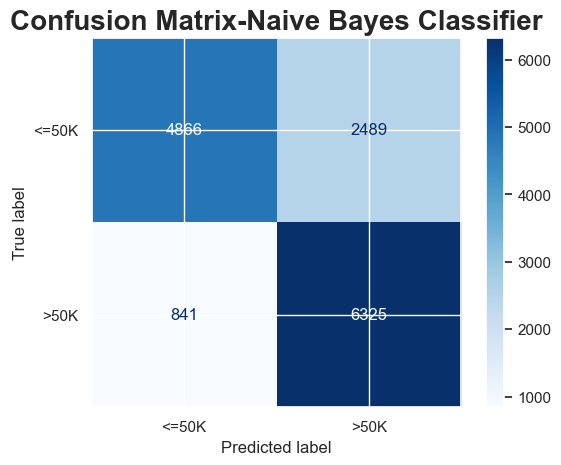

Train Score: 78.04
Test Score: 77.07
              precision    recall  f1-score   support

       False       0.85      0.66      0.75      7355
        True       0.72      0.88      0.79      7166

    accuracy                           0.77     14521
   macro avg       0.79      0.77      0.77     14521
weighted avg       0.79      0.77      0.77     14521



In [79]:
from sklearn.naive_bayes import GaussianNB


def evaluation_func(par):
    clf = GaussianNB()
    clf.fit(x_train, y_train)
    return -clf.score(x_test, y_test)

res = differential_evolution(evaluation_func, bounds=[(0, 1)], maxiter=15, mutation=0.9, recombination=0.8, popsize=20)

print(f"Score: {-res.fun*100:.2f}")

clf = GaussianNB()
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
matrix = confusion_matrix(y_test, y_pred)
figure = ConfusionMatrixDisplay(matrix, display_labels=["<=50K", ">50K"])
figure.plot(cmap="Blues")
plt.title("Confusion Matrix-Naive Bayes Classifier", fontsize=20, weight="bold")
plt.show()

train_score = clf.score(x_train, y_train)
test_score = clf.score(x_test, y_test)
print(f"Train Score: {train_score*100:.2f}\nTest Score: {test_score*100:.2f}")
report = classification_report(y_test, y_pred)
print(report)
